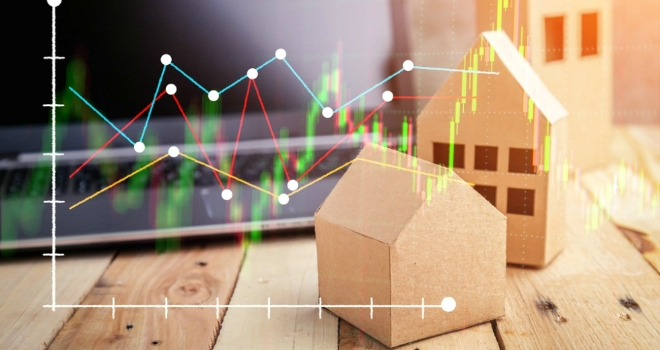

# > **Don't forget to upvote if you like my notebook. :)**

# **First step; import our library later read dataframes**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import seaborn as sb
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, KFold,GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler,RobustScaler,LabelEncoder,PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor,StackingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 5000)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
train=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
sample_sub=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

# **We must have knownledge about our data**

In [ ]:
train.head()

In [ ]:
train[train.SalePrice>300000]

In [ ]:
train.tail()

In [ ]:
train.info()

In [ ]:
train.describe()

# **Variables associated with SalePrice**

In [ ]:
correlation_train=train.corr()
sb.set(font_scale=2)
plt.figure(figsize = (50,35))
ax = sb.heatmap(correlation_train, annot=True,annot_kws={"size": 25},fmt='.1f',cmap='PiYG', linewidths=.5)

In [ ]:
correlation_train.columns

In [ ]:
corr_dict=correlation_train['SalePrice'].sort_values(ascending=False).to_dict()
important_columns=[]
for key,value in corr_dict.items():
    if ((value>0.1) & (value<0.8)) | (value<=-0.1):
        important_columns.append(key)
important_columns

# **In the visualization above, we can see the variables that affect SalePrice.**

In [ ]:
plt.figure(figsize=(40,20))
sb.set(font_scale=1.5)
sb.boxplot(x='YearBuilt', y="SalePrice", data=train)
sb.swarmplot(x='YearBuilt', y="SalePrice", data=train, color=".25")
plt.xticks(weight='bold',rotation=90)


In [ ]:
test.head()

# **We will predict SalePrice column**

In [ ]:
test.tail()

In [ ]:
test.info()

In [ ]:
test.describe()

# **Clean and Edit Dataframes**

# We must combine train and test datasets. Because This processes are must be carried out together.

In [ ]:
train_test=pd.concat([train,test],axis=0,sort=False)
train_test.head()

In [ ]:
pd.set_option('display.max_rows', 5000)
train_test_null_info=pd.DataFrame(train_test.isnull().sum(),columns=['Count of NaN'])
train_test_dtype_info=pd.DataFrame(train_test.dtypes,columns=['DataTypes'])
train_tes_info=pd.concat([train_test_null_info,train_test_dtype_info],axis=1)
train_tes_info

# Fillna and Feature Engineering

In [ ]:
train_test.loc[train_test['Fireplaces']==0,'FireplaceQu']='Nothing'
train_test['LotFrontage'] = train_test['LotFrontage'].fillna(train_test.groupby('1stFlrSF')['LotFrontage'].transform('mean'))
train_test['LotFrontage'].interpolate(method='linear',inplace=True)
train_test['LotFrontage']=train_test['LotFrontage'].astype(int)
train_test['MasVnrArea'] = train_test['MasVnrArea'].fillna(train_test.groupby('MasVnrType')['MasVnrArea'].transform('mean'))
train_test['MasVnrArea'].interpolate(method='linear',inplace=True)
train_test['MasVnrArea']=train_test['MasVnrArea'].astype(int)
train_test["Fence"] = train_test["Fence"].fillna("None")
train_test["FireplaceQu"] = train_test["FireplaceQu"].fillna("None")
train_test["Alley"] = train_test["Alley"].fillna("None")
train_test["PoolQC"] = train_test["PoolQC"].fillna("None")
train_test["MiscFeature"] = train_test["MiscFeature"].fillna("None")
train_test.loc[train_test['BsmtFinSF1']==0,'BsmtFinType1']='Unf'
train_test.loc[train_test['BsmtFinSF2']==0,'BsmtQual']='TA'
train_test['YrBltRmd']=train_test['YearBuilt']+train_test['YearRemodAdd']
train_test['Total_Square_Feet'] = (train_test['BsmtFinSF1'] + train_test['BsmtFinSF2'] + train_test['1stFlrSF'] + train_test['2ndFlrSF'] + train_test['TotalBsmtSF'])
train_test['Total_Bath'] = (train_test['FullBath'] + (0.5 * train_test['HalfBath']) + train_test['BsmtFullBath'] + (0.5 * train_test['BsmtHalfBath']))
train_test['Total_Porch_Area'] = (train_test['OpenPorchSF'] + train_test['3SsnPorch'] + train_test['EnclosedPorch'] + train_test['ScreenPorch'] + train_test['WoodDeckSF'])
train_test['exists_pool'] = train_test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_garage'] = train_test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_fireplace'] = train_test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_bsmt'] = train_test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train_test['old_house'] = train_test['YearBuilt'].apply(lambda x: 1 if x <1990 else 0)

for i in train_test.columns:
    if 'SalePrice' not in i:
        if 'object' in str(train_test[str(i)].dtype):
            train_test[str(i)]=train_test[str(i)].fillna(method='ffill')


In [ ]:
columns = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 'YrSold', 'MoSold', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond')

for col in columns:
    lbl_enc = LabelEncoder() 
    lbl_enc.fit(list(train_test[col].values)) 
    train_test[col] = lbl_enc.transform(list(train_test[col].values))

In [ ]:
numeric_features = train_test.dtypes[train_test.dtypes != "object"].index
skewed_features = train_test[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
print(skewed_features)

In [ ]:
high_skewness = skewed_features[abs(skewed_features) > 0.9]
skewed_features = high_skewness.index

In [ ]:
print(high_skewness)
print('\nVariables with high skewness: \n\n',skewed_features)

In [ ]:
train_test[['MiscVal', 'PoolArea', 'exists_pool', 'LotArea', 'LowQualFinSF', '3SsnPorch', 'LandSlope', 'KitchenAbvGr', 'EnclosedPorch',
       'ScreenPorch', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'LotFrontage', '1stFlrSF', 'Total_Porch_Area', 'GrLivArea', 'BsmtExposure',
       'KitchenQual', 'ExterQual', 'Fence', 'ExterCond', 'PavedDrive', 'BsmtCond', 'BsmtFinType2', 'CentralAir', 'GarageQual', 'exists_garage',
       'Functional', 'GarageCond', 'exists_bsmt', 'BsmtQual', 'Street','PoolQC']].head()

In [ ]:
for feature in skewed_features:
    train_test[feature] = boxcox1p(train_test[feature], boxcox_normmax(train_test[feature] + 1))


In [ ]:
train_test[['MiscVal', 'PoolArea', 'exists_pool', 'LotArea', 'LowQualFinSF', '3SsnPorch', 'LandSlope', 'KitchenAbvGr', 'EnclosedPorch',
       'ScreenPorch', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'LotFrontage', '1stFlrSF', 'Total_Porch_Area', 'GrLivArea', 'BsmtExposure',
       'KitchenQual', 'ExterQual', 'Fence', 'ExterCond', 'PavedDrive', 'BsmtCond', 'BsmtFinType2', 'CentralAir', 'GarageQual', 'exists_garage',
       'Functional', 'GarageCond', 'exists_bsmt', 'BsmtQual', 'Street','PoolQC']].head()

In [ ]:
train_test=pd.get_dummies(train_test,dtype='int8')

In [ ]:
train_test_null_info=pd.DataFrame(train_test.isnull().sum(),columns=['Count of NaN'])
train_test_dtype_info=pd.DataFrame(train_test.dtypes,columns=['DataTypes'])
train_test_info=pd.concat([train_test_null_info,train_test_dtype_info],axis=1)
train_test_info

# It's time to leave

In [ ]:
train=train_test[0:1460]
test=train_test[1460:2919]

In [ ]:
len(train)

In [ ]:
train.interpolate(method='linear',inplace=True)
test.interpolate(method='linear',inplace=True)

In [ ]:
corr_new_train=train.corr()
plt.figure(figsize=(5,15))
sb.heatmap(corr_new_train[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(30),annot_kws={"size": 16},vmin=-1, cmap='PiYG', annot=True)
sb.set(font_scale=2)

# These are the columns with the best correlation rate. Let's visualize them.

In [ ]:
corr_dict2=corr_new_train['SalePrice'].sort_values(ascending=False).to_dict()
corr_dict2

# Columns with more than 40% positive or negative correlations with SalePrice

In [ ]:
best_columns=[]
for key,value in corr_dict2.items():
    if ((value>=0.3175) & (value<0.9)) | (value<=-0.315):
        best_columns.append(key)
best_columns

In [ ]:
print(len(best_columns))

In [ ]:
plt.figure(figsize=(25,10))
sb.set(font_scale=1.4)
train.boxplot(column=best_columns)
plt.xticks(weight='bold',rotation=90)


In [ ]:
train['SalePrice_Log1p'] = np.log1p(train.SalePrice)

In [ ]:
train.head()

In [ ]:
print(min(train['SalePrice_Log1p']))
print(max(train['SalePrice_Log1p']))

In [ ]:
plt.figure(figsize=(10,8))
sb.set(font_scale=1.2)
sb.distplot(train['SalePrice'],color='violet')
plt.xlabel('SalePrice',fontsize=20)
print('Skew Dist:',train['SalePrice'].skew())
print('Kurtosis Dist:',train['SalePrice'].kurt())

In [ ]:
plt.figure(figsize=(10,8))
sb.set(font_scale=1.2)
sb.distplot(train['SalePrice_Log1p'],color='indigo')
plt.xlabel('SalePrice_Log1p',fontsize=20)
print('Skew Dist:',train['SalePrice_Log1p'].skew())
print('Kurtosis Dist:',train['SalePrice_Log1p'].kurt())

In [ ]:
print(len(train[(train.KitchenQual==3) & (train.SalePrice>360000)].index))

# With the help of the above visualizations, we detected outliers. Let's get rid!

In [ ]:
len(train)

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(20,12))
rbst_scaler=RobustScaler()
train_rbst=rbst_scaler.fit_transform(train)

pca=PCA(50).fit(train_rbst)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xticks(np.arange(0, 50, 1))
plt.xlabel('Number of components',fontweight='bold',size=14)
plt.ylabel('Explanined variance ratio for number of components',fontweight='bold',size=14)

train_pca=PCA(3).fit_transform(train_rbst)

In [ ]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(train)
distances, indices = nbrs.kneighbors(train)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(15,15))
plt.plot(distances)

In [ ]:
dbscan = DBSCAN(eps=1400, min_samples=20).fit(train_pca)
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels=dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [ ]:
unique_labels = set(labels)
plt.figure(figsize=(12,12))
colors = [plt.cm.prism(each)  for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xy = train_pca[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = train_pca[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
labels=pd.DataFrame(labels,columns=['Classes'])
print(labels[labels['Classes']==-1])

In [ ]:
train=pd.concat([train,labels],axis=1)

In [ ]:
train[train.Classes==-1]

In [ ]:
train.drop([197,810,1170,1182,1298,1386,1423],axis=0,inplace=True)

In [ ]:
plt.style.use('dark_background')
fig, axes = plt.subplots(18, 2,figsize=(20,80))
fig.subplots_adjust(hspace=0.6)
colors=[plt.cm.prism_r(each) for each in np.linspace(0, 1, len(best_columns))]
for i,ax,color in zip(best_columns,axes.flatten(),colors):
    sb.regplot(x=train[i], y=train["SalePrice"], fit_reg=True,marker='o',scatter_kws={'s':50,'alpha':0.8},color=color,ax=ax)
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice',fontsize=12)
    ax.set_yticks(np.arange(0,900001,100000))
    ax.set_title('SalePrice'+' - '+str(i),color=color,fontweight='bold',size=20)

In [ ]:
plt.style.use('ggplot')
fig, axes = plt.subplots(18, 2,figsize=(20,60))
fig.subplots_adjust(hspace=0.8)
sb.set(font_scale=1.2)
colors=[plt.cm.prism_r(each) for each in np.linspace(0, 1, len(best_columns))]
for i,ax,color in zip(best_columns,axes.flatten(),colors):
    sb.regplot(x=train[i], y=train["SalePrice_Log1p"], fit_reg=True,marker='o',scatter_kws={'s':50,'alpha':0.7},color=color,ax=ax)
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice_Log1p',fontsize=12)
    ax.set_title('SalePrice_Log1p'+' - '+str(i),color=color,fontweight='bold',size=20)

In [ ]:
"Looking at the SalePrice and SalePrice_Log1p visualizations"

#train = train.drop(train[(train.OverallQual==4) & (train.SalePrice>200000)].index)
#train = train.drop(train[(train.OverallQual==10) & (train.SalePrice<200000)].index)
#train = train.drop(train[(train.Total_Square_Feet>=10000) & (train.SalePrice<200000)].index)
#train = train.drop(train[(train.Total_SF<3000) & (train.SalePrice>375000)].index)
#train = train.drop(train[(train.GrLivArea>4500) & (train.SalePrice<200000)].index)
#train = train.drop(train[(train.GrLivArea<3000) & (train.SalePrice>575000)].index)
#train = train.drop(train[(train.GarageArea>1200) & (train.SalePrice<165000)].index)
#train = train.drop(train[(train.Total_Bath.isin([5,6])) & (train.SalePrice<200000)].index)
#train = train.drop(train[(train.TotRmsAbvGrd==10) & (train.SalePrice>700000)].index)
#train = train.drop(train[(train.YearBuilt<1900) & (train.SalePrice>250000)].index)
#train = train.drop(train[(train.YearBuilt>2000) & (train.SalePrice<100000)].index)
#train = train.drop(train[(train.YearRemodAdd<1970) & (train.SalePrice>350000)].index)
#train = train.drop(train[(train.MasVnrArea>=1400) & (train.SalePrice<250000)].index)
#train = train.drop(train[(train.GarageYrBlt<1960) & (train.SalePrice>340000)].index)
#train = train.drop(train[(train.Total_Porch_Area>600) & (train.SalePrice<50000)].index)
#train = train.drop(train[(train.LotFrontage>150) & (train.SalePrice<100000)].index)
#train = train.drop(train[(train.GarageFinish.isin([1,2])) & (train.SalePrice>470000)].index)
#train = train.drop(train[(train.old_house==0) & (train.SalePrice<100000)].index)
#train = train.drop(train[(train.old_house==1) & (train.SalePrice>400000)].index)
#train = train.drop(train[(train.KitchenQual==2) & (train.SalePrice>600000)].index)
#train = train.drop(train[(train.KitchenQual==3) & (train.SalePrice>360000)].index)
#train = train.drop(train[(train.ExterQual==2) & (train.SalePrice>550000)].index)


train = train[train.GarageArea * train.GarageCars < 3700]
train = train[(train.FullBath + (train.HalfBath*0.5) + train.BsmtFullBath + (train.BsmtHalfBath*0.5))<5]

In [ ]:
len(train)

# Correlations increased after the outliers were removed.

In [ ]:
plt.style.use('dark_background')
corr1_new_train=train.corr()
plt.figure(figsize=(5,15))
sb.heatmap(corr1_new_train[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(25),annot_kws={"size": 16},vmin=-1, cmap='PiYG', annot=True)
sb.set(font_scale=2)

In [ ]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

In [ ]:
del test['SalePrice']

In [ ]:
train.head()

# **Create Model**

In [ ]:
X=train.drop(['SalePrice','SalePrice_Log1p','Classes'],axis=1)
y=train.SalePrice_Log1p

In [ ]:
def overfit_reducer(df):

    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.9:
            overfit.append(i)
    overfit = list(overfit)
    return overfit
overfitted_features = overfit_reducer(X)

In [ ]:
print(X.shape)
print(test.shape)

In [ ]:
X.drop(overfitted_features,axis=1,inplace=True)
test.drop(overfitted_features,axis=1,inplace=True)
print('X.shape',X.shape)
print('test.shape',test.shape)

In [ ]:
std_scaler=StandardScaler()
rbst_scaler=RobustScaler()
power_transformer=PowerTransformer()
X_std=std_scaler.fit_transform(X)
X_rbst=rbst_scaler.fit_transform(X)
X_pwr=power_transformer.fit_transform(X)

test_std=std_scaler.transform(test)
test_rbst=rbst_scaler.transform(test)
test_pwr=power_transformer.transform(test)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_std,y,test_size=0.002,random_state=52)
print('X_train Shape :',X_train.shape)
print('X_test Shape :',X_test.shape)
print('y_train Shape :',y_train.shape)
print('y_test Shape :',y_test.shape)

In [ ]:
lgb_regressor=lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.035, n_estimators=2177, max_bin=50, bagging_fraction=0.65,bagging_freq=5, bagging_seed=7, 
                                feature_fraction=0.201, feature_fraction_seed=7,n_jobs=-1)
lgb_regressor.fit(X_train, y_train)
y_head=lgb_regressor.predict(X_test)
print('-'*10+'LGBM'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

In [ ]:
gb_reg = GradientBoostingRegressor(n_estimators=1992, learning_rate=0.03005, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=14, loss='huber', random_state =42)
gb_reg.fit(X_train, y_train)
y_head=gb_reg.predict(X_test)
print('-'*10+'GBR'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

In [ ]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

alphas=[1e-9,1e-8,1e-7,1e-6]

ridgecv_reg= make_pipeline(RidgeCV(alphas=alphas, cv=kfolds))
ridgecv_reg.fit(X_train, y_train)
y_head=ridgecv_reg.predict(X_test)
print('-'*10+'RidgeCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

In [ ]:
kfolds = KFold(n_splits=8, shuffle=True, random_state=42)

lassocv_reg= make_pipeline(LassoCV(alphas=alphas, cv=kfolds))
lassocv_reg.fit(X_train, y_train)
y_head=lassocv_reg.predict(X_test)
print('-'*10+'LassoCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

In [ ]:
kfolds = KFold(n_splits=8, shuffle=True, random_state=42)

alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006]
l1ratio=[0.87, 0.9,0.92, 0.95,0.97, 0.99, 1]

elasticv_reg= make_pipeline(ElasticNetCV(alphas=alphas, cv=kfolds, l1_ratio=l1ratio))
elasticv_reg.fit(X_train, y_train)
y_head=elasticv_reg.predict(X_test)
print('-'*10+'ElasticNetCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

In [ ]:
estimators = [('lgbm', lgb_regressor),
              ('gbr', gb_reg),   
              ('lasso', lassocv_reg),   
              ('ridge', ridgecv_reg),   
              ('elasticnet', elasticv_reg)]

stack_reg=StackingRegressor(estimators=estimators,final_estimator=ExtraTreesRegressor(n_estimators=50),n_jobs=-1)
stack_reg.fit(X_train, y_train)
y_head=stack_reg.predict(X_test)
print('-'*10+'StackingRegressor'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

In [ ]:
y_head=pd.DataFrame(y_head,columns=['Predict'])
y_test.reset_index(drop=True,inplace=True)
y_test_y_head=pd.concat([y_test,y_head],axis=1)
y_test_y_head.head()

In [ ]:
print('Count columns of test: ',len(test.columns))
print('Count columns of X: ',len(X.columns))

In [ ]:
test_pred_lgb=lgb_regressor.predict(test_pwr)
test_pred_gb=gb_reg.predict(test_pwr)
test_pred_elastic=elasticv_reg.predict(test_pwr)
test_pred_ridge=ridgecv_reg.predict(test_pwr)
test_pred_lasso=lassocv_reg.predict(test_pwr)
test_pred_stack=stack_reg.predict(test_pwr)

In [ ]:
test_pred_lgb=pd.DataFrame(test_pred_lgb,columns=['SalePrice'])
test_pred_gb=pd.DataFrame(test_pred_gb,columns=['SalePrice'])
test_pred_elastic=pd.DataFrame(test_pred_elastic,columns=['SalePrice'])
test_pred_ridge=pd.DataFrame(test_pred_ridge,columns=['SalePrice'])
test_pred_lasso=pd.DataFrame(test_pred_lasso,columns=['SalePrice'])
test_pred_stack=pd.DataFrame(test_pred_stack,columns=['SalePrice'])

In [ ]:
test_pred_lgb.SalePrice =np.floor(np.expm1(test_pred_lgb.SalePrice))
test_pred_gb.SalePrice =np.floor(np.expm1(test_pred_gb.SalePrice))
test_pred_elastic.SalePrice =np.floor(np.expm1(test_pred_elastic.SalePrice))
test_pred_ridge.SalePrice =np.floor(np.expm1(test_pred_ridge.SalePrice))
test_pred_lasso.SalePrice =np.floor(np.expm1(test_pred_lasso.SalePrice))
test_pred_stack.SalePrice =np.floor(np.expm1(test_pred_stack.SalePrice))

In [ ]:
test_pred_lgb.head()

In [ ]:
test_pred_gb.head()

In [ ]:
test_pred_elastic.head()

In [ ]:
test_pred_ridge.head()

In [ ]:
test_pred_lasso.head()

In [ ]:
test_pred_stack.head()

In [ ]:
final_pred=(test_pred_stack*0.1665)+(test_pred_lgb*0.678)+(test_pred_ridge*0.1665)
final_pred.head()

In [ ]:
sample_sub['SalePrice']=final_pred

In [ ]:
sample_sub.head()

In [ ]:
sample_sub.to_csv('SampleSubmissionForHousePrice.csv',index=False)